In [1]:
!pip install gymnasium pandas numpy matplotlib seaborn stable-baselines3 sb3-contrib scikit-learn torch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.9 MB/s eta 0:00:00


Loading data from reliance_30.csv ...
Processed dataset: train=22226, test=5557, features=7

 TRAINING MASKED PPO + 1D CNN 
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | -25.1    |
| time/              |          |
|    fps             | 342      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2e+03        |
|    ep_rew_mean          | -19.8        |
| time/                   |              |
|    fps                  | 319          |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx

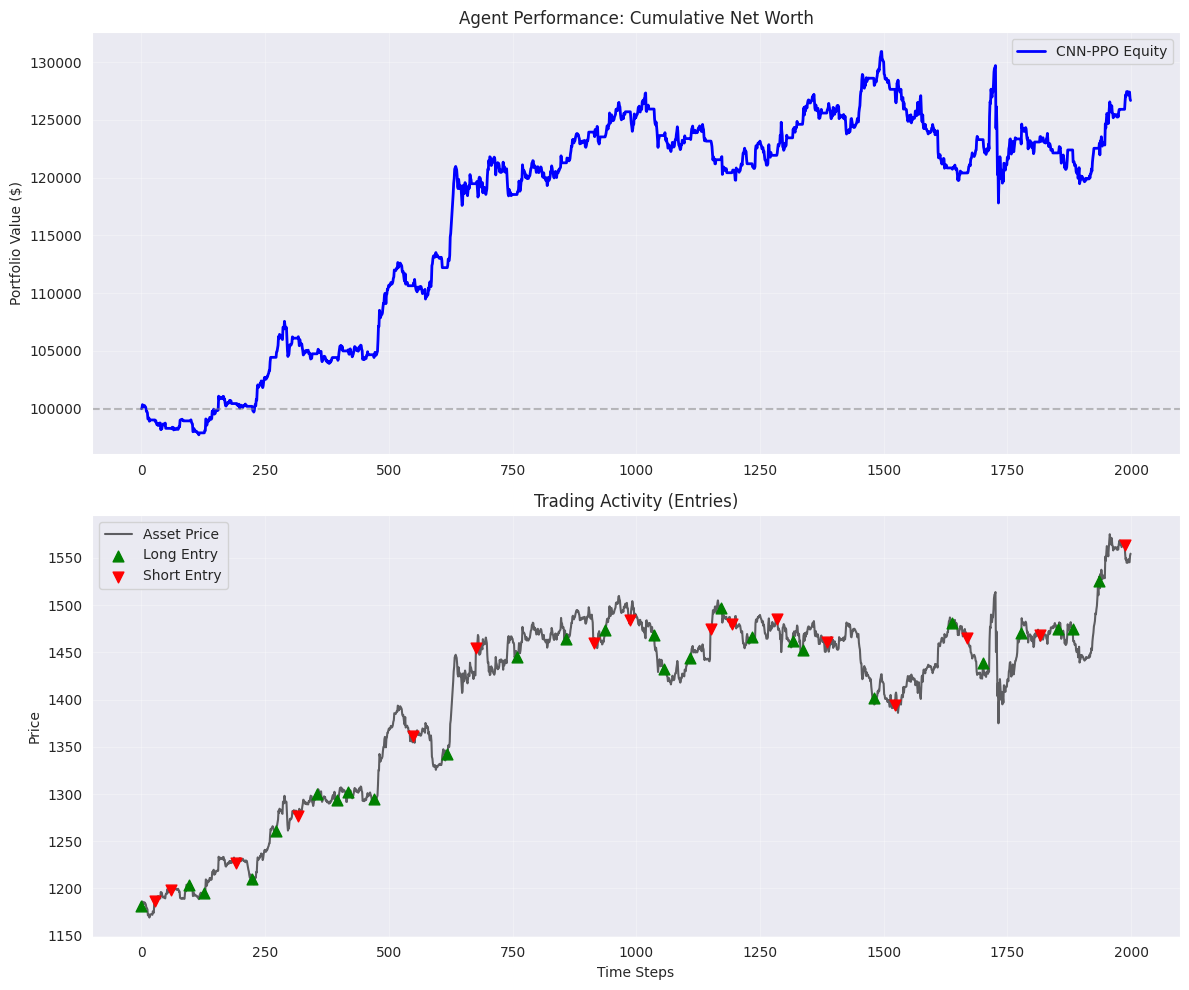

In [6]:
#!/usr/bin/env python3
"""
RESEARCH PAPER CODE: MASKED PPO + 1D CNN (FIXED)
------------------------------------------------
Base Logic: Dhruv (Rigorous Data Processing, Action Masking, Swing Constraints)
Neural Net: Shubham (1D Convolutional Neural Network for Feature Extraction)
Plotting:   Shubham (Seaborn style, Dual-panel Equity & Trade visualization)

Fixes:
- Solved 'math domain error' by handling bankruptcy (Net Worth <= 0).
- Fixed accounting logic to correctly update Balance when opening trades.
- Compatible with Gymnasium.
"""

import math
import warnings
import argparse
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium import spaces

# SB3 & Contrib
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sklearn.preprocessing import RobustScaler, StandardScaler

# Suppress warnings for clean research output
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
th.set_num_threads(1)


# ==========================================
# 1. CNN ARCHITECTURE (Shubham's Net)
# ==========================================
class OneD_CNN_Extractor(BaseFeaturesExtractor):
    """
    1D-CNN Feature Extractor for Time Series.
    Input shape: (Batch, N_Features, Lookback_Window)
    """
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128):
        super(OneD_CNN_Extractor, self).__init__(observation_space, features_dim)

        # observation_space.shape is (N_Features, Lookback)
        n_input_channels = observation_space.shape[0]

        self.cnn = nn.Sequential(
            # Layer 1: Short-term patterns
            nn.Conv1d(n_input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            # Layer 2: Long-term trends
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten(),
        )

        # Compute dynamic output shape to connect to Linear layer
        with th.no_grad():
            sample_input = th.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample_input).shape[1]

        self.linear = nn.Linear(n_flatten, features_dim)

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))


# ==========================================
# 2. DATA PROCESSOR (Dhruv's Robust Logic)
# ==========================================
class DataProcessor:
    def __init__(self):
        self.scalers = {}
        self.feature_cols_dict = None

    def process_data(self, filepath):
        print(f"Loading data from {filepath} ...")
        try:
            df = pd.read_csv(filepath)
            df.columns = df.columns.str.strip().str.lower()
            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.sort_values('timestamp').reset_index(drop=True)

            # Ensure numeric
            for col in ['open', 'high', 'low', 'close', 'volume']:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            # --- Feature Engineering ---
            df['returns'] = df['close'].pct_change()
            df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

            ema12 = df['close'].ewm(span=12, adjust=False).mean()
            ema26 = df['close'].ewm(span=26, adjust=False).mean()
            df['macd'] = ema12 - ema26

            # RSI
            delta = df['close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-10)
            df['rsi'] = 100 - (100 / (1 + rs))

            # Bollinger Bands
            df['sma20'] = df['close'].rolling(20).mean()
            df['std20'] = df['close'].rolling(20).std()
            df['bb_upper'] = df['sma20'] + (df['std20'] * 2)
            df['bb_lower'] = df['sma20'] - (df['std20'] * 2)
            df['bb_pos'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'] + 1e-10)

            # ATR
            high_low = df['high'] - df['low']
            high_close = np.abs(df['high'] - df['close'].shift())
            low_close = np.abs(df['low'] - df['close'].shift())
            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
            df['atr'] = tr.rolling(14).mean()

            # Volume Ratio
            df['vol_sma'] = df['volume'].rolling(20).mean()
            df['vol_ratio'] = df['volume'] / (df['vol_sma'] + 1e-10)

            df.dropna(inplace=True)
            df.reset_index(drop=True, inplace=True)

            feature_cols = {
                'stationary': ['log_returns', 'returns'],
                'unbounded': ['macd', 'atr'],
                'bounded': ['rsi', 'bb_pos'],
                'ratio': ['vol_ratio']
            }

            all_feats = []
            for v in feature_cols.values():
                all_feats.extend(v)

            # Split Train/Test
            train_size = int(len(df) * 0.8)
            train_df = df.iloc[:train_size].copy()
            test_df = df.iloc[train_size:].copy()

            print(f"Processed dataset: train={len(train_df)}, test={len(test_df)}, features={len(all_feats)}")
            return train_df, test_df, all_feats, feature_cols

        except FileNotFoundError:
            print("CSV not found — generating synthetic data for testing.")
            return self._generate_synthetic_data()

    def _generate_synthetic_data(self):
        np.random.seed(42)
        n = 4000
        t = np.linspace(0, 50, n)
        trend = 2000 + t * 10
        cycle = 100 * np.sin(t * 0.5)
        noise = np.random.normal(0, 20, n)
        close = trend + cycle + noise
        dates = pd.date_range(start='2020-01-01', periods=n, freq='30min')

        df = pd.DataFrame({
            'timestamp': dates,
            'open': close * (1 + np.random.uniform(-0.01, 0.01, n)),
            'high': close * (1 + np.random.uniform(0, 0.02, n)),
            'low': close * (1 - np.random.uniform(0, 0.02, n)),
            'close': close,
            'volume': np.random.lognormal(10, 1, n)
        })
        df.to_csv('synthetic_data.csv', index=False)
        return self.process_data('synthetic_data.csv')

    def fit_normalizers(self, train_df, feature_cols_dict):
        self.feature_cols_dict = feature_cols_dict
        if feature_cols_dict.get('stationary'):
            self.scalers['stationary'] = StandardScaler()
            self.scalers['stationary'].fit(train_df[feature_cols_dict['stationary']])
        if feature_cols_dict.get('unbounded'):
            self.scalers['unbounded'] = RobustScaler()
            self.scalers['unbounded'].fit(train_df[feature_cols_dict['unbounded']])

    def transform(self, df):
        parts = []
        if self.feature_cols_dict.get('stationary'):
            f = self.feature_cols_dict['stationary']
            parts.append(self.scalers['stationary'].transform(df[f]))
        if self.feature_cols_dict.get('unbounded'):
            f = self.feature_cols_dict['unbounded']
            parts.append(self.scalers['unbounded'].transform(df[f]))
        if self.feature_cols_dict.get('bounded'):
            f = self.feature_cols_dict['bounded']
            vals = df[f].values
            parts.append(((vals - 50.0) / 50.0))
        if self.feature_cols_dict.get('ratio'):
            f = self.feature_cols_dict['ratio']
            vals = np.log1p(df[f].values.clip(min=0))
            parts.append(vals)

        arr = np.hstack(parts).astype(np.float32)
        return arr


# ==========================================
# 3. TRADING ENV (Fixed Logic)
# ==========================================
class ResearchTradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        normalized_features: np.ndarray,
        lookback: int = 60,
        initial_balance: float = 100_000.0,
        commission: float = 0.001,
        min_hold_period: int = 5,
        max_episode_steps: int = 2000,
    ):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.features = normalized_features
        self.lookback = int(lookback)
        self.initial_balance = float(initial_balance)
        self.commission = float(commission)
        self.min_hold_period = int(min_hold_period)
        self.max_episode_steps = int(max_episode_steps)

        # 0=SHORT, 1=NEUTRAL, 2=LONG
        self.action_space = gym.spaces.Discrete(3)

        n_features = self.features.shape[1]

        # Shape: (Features, Lookback) for 1D-CNN
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(n_features, self.lookback),
            dtype=np.float32
        )

        self.reset()

    def _get_obs(self) -> np.ndarray:
        s = self.current_step
        start = s - self.lookback
        block = self.features[start:s]
        # Transpose: (Lookback, Features) -> (Features, Lookback)
        return block.T.astype(np.float32)

    def _get_current_position(self) -> int:
        # Tolerance for float comparison
        if self.shares > 1e-8: return 2
        if self.shares < -1e-8: return 0
        return 1

    def valid_action_mask(self) -> np.ndarray:
        mask = np.ones(3, dtype=bool)
        curr = self._get_current_position()

        # Prevent direct flips
        if curr == 2:   mask[0] = False
        elif curr == 0: mask[2] = False

        # Enforce Minimum Holding Period
        if (self.last_trade_step is not None) and ((self.current_step - self.last_trade_step) < self.min_hold_period):
            forced = np.zeros(3, dtype=bool)
            forced[curr] = True
            mask = forced

        return mask

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        # Random start index for diversity, or fixed for testing
        self.current_step = self.lookback

        self.balance = self.initial_balance
        self.shares = 0.0
        self.net_worth = self.initial_balance
        self.last_trade_step = -9999
        self.trades_count = 0
        self.step_in_episode = 0

        self.history = {"net_worth": [], "action": [], "exec_price": [], "date": []}
        return self._get_obs(), {}

    def step(self, action: int):
        action = int(action)
        price = float(self.df["close"].iloc[self.current_step])
        prev_net_worth = self.net_worth

        mask = self.valid_action_mask()
        curr_pos = self._get_current_position()

        # Enforce Mask
        if not mask[action]:
            action = curr_pos

        traded = False

        # EXECUTE TRADE LOGIC
        if action != curr_pos:

            # 1. Close Existing Position
            # We treat Net Worth as the 'Cash Equivalent' value of the portfolio
            # to simplify closing logic (Cash + Position Value).
            # This handles both Long and Short closing correctly in a simplified manner.

            # If closing a Short (shares < 0), self.shares * price is negative liability.
            # Balance needs to pay that liability.
            # However, in our simple model:
            # Net Worth is the ground truth of equity.

            current_equity = self.balance + (self.shares * price)

            # Apply commission on the transaction required to close
            # Value traded to close = abs(shares * price)
            closing_comm = abs(self.shares * price) * self.commission
            current_equity -= closing_comm

            # Now we are fully in cash (Equity)
            self.balance = current_equity
            self.shares = 0.0

            # 2. Open New Position (if not going Neutral)
            if action != 1:
                # Available cash for new trade
                # Leverage = 1.0 (Full equity)
                total_funds = self.balance

                # Deduct opening commission estimate
                # trade_val + trade_val*comm = total_funds => trade_val = total_funds / (1+comm)
                trade_value = total_funds / (1 + self.commission)

                if trade_value > 0:
                    if action == 2: # LONG
                        self.shares = trade_value / price
                        self.balance -= trade_value # Cash converted to shares
                    elif action == 0: # SHORT
                        # In Short: Balance becomes Cash + Short Proceeds
                        self.shares = -(trade_value / price)
                        self.balance += trade_value

            self.last_trade_step = self.current_step
            self.trades_count += 1
            traded = True

        # Update Net Worth
        self.net_worth = self.balance + (self.shares * price)

        # REWARD & TERMINATION
        terminated = False
        reward = 0.0

        # 1. Check Bankruptcy
        if self.net_worth <= 1.0: # Basically zero
            reward = -10.0 # Fail penalty
            terminated = True
            self.net_worth = 0.0
        else:
            # 2. Calculate Log Return
            # Use max to safeguard against tiny division
            ratio = self.net_worth / max(prev_net_worth, 1e-9)
            reward = math.log(ratio) * 100.0
            if traded: reward -= 0.05 # Small friction penalty

        # Update Steps
        self.current_step += 1
        self.step_in_episode += 1

        if (self.current_step >= len(self.df) - 1) or (self.step_in_episode >= self.max_episode_steps):
            terminated = True

        # Record
        self.history["net_worth"].append(self.net_worth)
        self.history["action"].append(int(action))
        self.history["exec_price"].append(price)
        self.history["date"].append(self.df["timestamp"].iloc[self.current_step])

        return self._get_obs(), reward, terminated, False, {}

    def mask_fn(self):
        return self.valid_action_mask()


# ==========================================
# 4. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":

    # 1. Configuration
    parser = argparse.ArgumentParser()
    parser.add_argument("--filename", type=str, default="reliance_30.csv")
    parser.add_argument("--timesteps", type=int, default=45000)
    args = parser.parse_args([])

    # 2. Data
    processor = DataProcessor()
    train_df, test_df, all_feats, feature_cols = processor.process_data(args.filename)
    processor.fit_normalizers(train_df, feature_cols)
    train_norm = processor.transform(train_df)
    test_norm = processor.transform(test_df)

    # 3. Environment Factory
    def make_env(df, norm):
        env = ResearchTradingEnv(df, norm, lookback=60, min_hold_period=10)
        return ActionMasker(env, ResearchTradingEnv.mask_fn)

    train_env = make_env(train_df, train_norm)
    test_env = make_env(test_df, test_norm)

    # 4. Model Setup (Hybrid: Dhruv Env + Shubham CNN)
    policy_kwargs = dict(
        features_extractor_class=OneD_CNN_Extractor,
        features_extractor_kwargs=dict(features_dim=128),
        net_arch=[dict(pi=[64, 64], vf=[64, 64])]
    )

    print("\n" + "="*40)
    print(" TRAINING MASKED PPO + 1D CNN ")
    print("="*40)

    model = MaskablePPO(
        "MlpPolicy",
        train_env,
        policy_kwargs=policy_kwargs,
        learning_rate=3e-4,
        verbose=1,
        device='auto' # Uses GPU if available
    )

    model.learn(total_timesteps=args.timesteps)
    model.save("ppo_cnn_swing_research")

    # 5. Evaluation
    print("\n" + "="*40)
    print(" EVALUATING PERFORMANCE ")
    print("="*40)

    obs, _ = test_env.reset()
    done = False

    while not done:
        mask = test_env.env.valid_action_mask()
        action, _ = model.predict(obs, action_masks=mask, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(int(action))
        done = terminated or truncated

    # 6. Metrics & Plotting
    history = test_env.env.history
    net_worths = np.array(history["net_worth"])
    actions = np.array(history["action"])
    prices = np.array(history["exec_price"])

    total_ret = (net_worths[-1] - net_worths[0]) / net_worths[0] * 100

    print(f"Final Balance    : ${net_worths[-1]:,.2f}")
    print(f"Total Return     : {total_ret:.2f}%")
    print(f"Trades Executed  : {test_env.env.trades_count}")

    # Plotting (Shubham's Style)
    plt.figure(figsize=(12, 10))

    # Panel 1: Equity
    plt.subplot(2, 1, 1)
    plt.plot(net_worths, color='blue', linewidth=2, label='CNN-PPO Equity')
    plt.axhline(y=net_worths[0], color='gray', linestyle='--', alpha=0.5)
    plt.title('Agent Performance: Cumulative Net Worth')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Panel 2: Price & Trades
    plt.subplot(2, 1, 2)
    plt.plot(prices, color='black', alpha=0.6, label='Asset Price')

    # Markers (Change of State)
    # We detect where action changed to identify entries
    # 2=Long, 0=Short.
    long_entries = []
    short_entries = []

    prev_a = 1
    for i, a in enumerate(actions):
        if a == 2 and prev_a != 2:
            long_entries.append(i)
        elif a == 0 and prev_a != 0:
            short_entries.append(i)
        prev_a = a

    if long_entries:
        plt.scatter(long_entries, prices[long_entries], marker='^', color='green', s=60, label='Long Entry', zorder=5)
    if short_entries:
        plt.scatter(short_entries, prices[short_entries], marker='v', color='red', s=60, label='Short Entry', zorder=5)

    plt.title('Trading Activity (Entries)')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('Research_Performance_Report.png', dpi=300)
    print("Performance Report saved.")
    plt.show()

Loading data from reliance_30.csv ...
Processed: train=22226, test=5557, features=7

 TRAINING MASKED PPO + TRANSFORMER ATTENTION 
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | -10.7    |
| time/              |          |
|    fps             | 276      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2e+03        |
|    ep_rew_mean          | -6.13        |
| time/                   |              |
|    fps                  | 245          |
|    iterations           | 2            |
|    time_elapsed         | 16           |
|    total_timesteps      | 4096         |
| train/                  |              |
|   

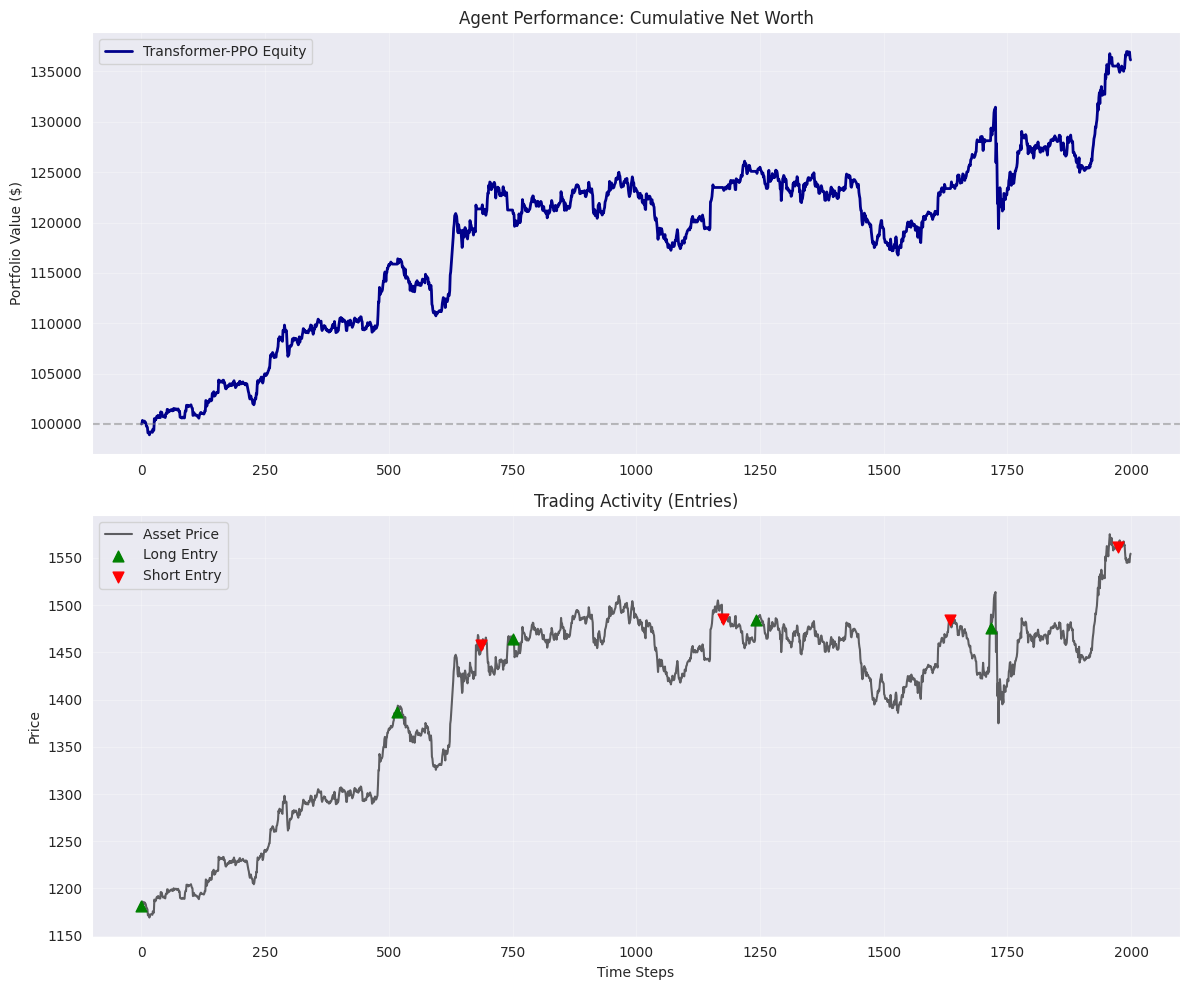

In [9]:
#!/usr/bin/env python3
"""
RESEARCH PAPER CODE: MASKED PPO + TRANSFORMER
---------------------------------------------
Base Logic: Dhruv (Rigorous Data Processing, Action Masking, Swing Constraints)
Neural Net: Transformer Encoder (Self-Attention mechanism)
Plotting:   Shubham (Seaborn style)

Usage:
    python research_transformer.py --filename reliance_30.csv
"""

import math
import warnings
import argparse
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium import spaces

# SB3 & Contrib
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sklearn.preprocessing import RobustScaler, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
th.set_num_threads(1)


# ==========================================
# 1. TRANSFORMER ARCHITECTURE
# ==========================================
class TimeSeriesTransformer(BaseFeaturesExtractor):
    """
    Transformer Encoder for Time Series Forecasting/Trading.
    Input shape from Env: (Batch, N_Features, Lookback_Window)
    Internal processing:  Transposes to (Batch, Lookback, N_Features) for Attention.
    """
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128,
                 d_model: int = 64, nhead: int = 4, num_layers: int = 2):
        super(TimeSeriesTransformer, self).__init__(observation_space, features_dim)

        # Observation shape: (N_Features, Lookback)
        n_features = observation_space.shape[0]
        self.lookback = observation_space.shape[1]

        # 1. Input Projection: Map features to d_model
        self.input_projection = nn.Linear(n_features, d_model)

        # 2. Positional Encoding: Learnable parameter to give time context
        self.pos_embedding = nn.Parameter(th.randn(1, self.lookback, d_model))

        # 3. Transformer Encoder Layer
        # batch_first=True is crucial because SB3 passes batches
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Output Head
        self.layer_norm = nn.LayerNorm(d_model)
        self.linear = nn.Linear(d_model, features_dim)

    def forward(self, observations: th.Tensor) -> th.Tensor:
        # Input: (Batch, Features, Time)
        # Transformer expects: (Batch, Time, Features) due to batch_first=True

        # 1. Permute dimensions
        x = observations.permute(0, 2, 1)

        # 2. Project Features
        x = self.input_projection(x)

        # 3. Add Positional Encoding
        # Broadcasts along batch dimension
        x = x + self.pos_embedding

        # 4. Pass through Transformer
        # Output: (Batch, Time, d_model)
        x = self.transformer_encoder(x)

        # 5. Aggregation
        # We take the embedding of the *last* time step (most recent price action)
        # as it contains the aggregated context of the whole window.
        x = x[:, -1, :]

        # 6. Final Projection
        x = self.layer_norm(x)
        return self.linear(x)


# ==========================================
# 2. DATA PROCESSOR (Rigorous)
# ==========================================
class DataProcessor:
    def __init__(self):
        self.scalers = {}
        self.feature_cols_dict = None

    def process_data(self, filepath):
        print(f"Loading data from {filepath} ...")
        try:
            df = pd.read_csv(filepath)
            df.columns = df.columns.str.strip().str.lower()
            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.sort_values('timestamp').reset_index(drop=True)

            for col in ['open', 'high', 'low', 'close', 'volume']:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            # --- Feature Engineering ---
            df['returns'] = df['close'].pct_change()
            df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

            ema12 = df['close'].ewm(span=12, adjust=False).mean()
            ema26 = df['close'].ewm(span=26, adjust=False).mean()
            df['macd'] = ema12 - ema26

            delta = df['close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-10)
            df['rsi'] = 100 - (100 / (1 + rs))

            df['sma20'] = df['close'].rolling(20).mean()
            df['std20'] = df['close'].rolling(20).std()
            df['bb_upper'] = df['sma20'] + (df['std20'] * 2)
            df['bb_lower'] = df['sma20'] - (df['std20'] * 2)
            df['bb_pos'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'] + 1e-10)

            tr = pd.concat([
                df['high'] - df['low'],
                np.abs(df['high'] - df['close'].shift()),
                np.abs(df['low'] - df['close'].shift())
            ], axis=1).max(axis=1)
            df['atr'] = tr.rolling(14).mean()

            df['vol_sma'] = df['volume'].rolling(20).mean()
            df['vol_ratio'] = df['volume'] / (df['vol_sma'] + 1e-10)

            df.dropna(inplace=True)
            df.reset_index(drop=True, inplace=True)

            feature_cols = {
                'stationary': ['log_returns', 'returns'],
                'unbounded': ['macd', 'atr'],
                'bounded': ['rsi', 'bb_pos'],
                'ratio': ['vol_ratio']
            }

            all_feats = []
            for v in feature_cols.values():
                all_feats.extend(v)

            train_size = int(len(df) * 0.8)
            train_df = df.iloc[:train_size].copy()
            test_df = df.iloc[train_size:].copy()

            print(f"Processed: train={len(train_df)}, test={len(test_df)}, features={len(all_feats)}")
            return train_df, test_df, all_feats, feature_cols

        except FileNotFoundError:
            print("CSV not found. Generating synthetic data.")
            return self._generate_synthetic_data()

    def _generate_synthetic_data(self):
        np.random.seed(42)
        n = 4000
        t = np.linspace(0, 50, n)
        trend = 2000 + t * 10
        cycle = 100 * np.sin(t * 0.5)
        noise = np.random.normal(0, 20, n)
        close = trend + cycle + noise
        dates = pd.date_range(start='2020-01-01', periods=n, freq='30min')

        df = pd.DataFrame({
            'timestamp': dates,
            'open': close, 'high': close*1.01, 'low': close*0.99, 'close': close,
            'volume': np.random.lognormal(10, 1, n)
        })
        df.to_csv('synthetic_data.csv', index=False)
        return self.process_data('synthetic_data.csv')

    def fit_normalizers(self, train_df, feature_cols_dict):
        self.feature_cols_dict = feature_cols_dict
        if feature_cols_dict.get('stationary'):
            self.scalers['stationary'] = StandardScaler()
            self.scalers['stationary'].fit(train_df[feature_cols_dict['stationary']])
        if feature_cols_dict.get('unbounded'):
            self.scalers['unbounded'] = RobustScaler()
            self.scalers['unbounded'].fit(train_df[feature_cols_dict['unbounded']])

    def transform(self, df):
        parts = []
        if self.feature_cols_dict.get('stationary'):
            f = self.feature_cols_dict['stationary']
            parts.append(self.scalers['stationary'].transform(df[f]))
        if self.feature_cols_dict.get('unbounded'):
            f = self.feature_cols_dict['unbounded']
            parts.append(self.scalers['unbounded'].transform(df[f]))
        if self.feature_cols_dict.get('bounded'):
            f = self.feature_cols_dict['bounded']
            vals = df[f].values
            parts.append(((vals - 50.0) / 50.0))
        if self.feature_cols_dict.get('ratio'):
            f = self.feature_cols_dict['ratio']
            vals = np.log1p(df[f].values.clip(min=0))
            parts.append(vals)
        return np.hstack(parts).astype(np.float32)


# ==========================================
# 3. TRADING ENV (Fixed Logic)
# ==========================================
class ResearchTradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        normalized_features: np.ndarray,
        lookback: int = 60,
        initial_balance: float = 100_000.0,
        commission: float = 0.001,
        min_hold_period: int = 5,
        max_episode_steps: int = 2000,
    ):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.features = normalized_features
        self.lookback = int(lookback)
        self.initial_balance = float(initial_balance)
        self.commission = float(commission)
        self.min_hold_period = int(min_hold_period)
        self.max_episode_steps = int(max_episode_steps)

        # 0=SHORT, 1=NEUTRAL, 2=LONG
        self.action_space = gym.spaces.Discrete(3)

        # Shape: (Features, Lookback) - kept standard for Data Consistency
        # Transformer class will transpose this internally.
        n_features = self.features.shape[1]
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(n_features, self.lookback),
            dtype=np.float32
        )
        self.reset()

    def _get_obs(self) -> np.ndarray:
        s = self.current_step
        start = s - self.lookback
        block = self.features[start:s]
        return block.T.astype(np.float32)

    def _get_current_position(self) -> int:
        if self.shares > 1e-8: return 2
        if self.shares < -1e-8: return 0
        return 1

    def valid_action_mask(self) -> np.ndarray:
        mask = np.ones(3, dtype=bool)
        curr = self._get_current_position()

        # No Direct Flips
        if curr == 2:   mask[0] = False
        elif curr == 0: mask[2] = False

        # Enforce Minimum Holding Period
        if (self.last_trade_step is not None) and ((self.current_step - self.last_trade_step) < self.min_hold_period):
            forced = np.zeros(3, dtype=bool)
            forced[curr] = True
            mask = forced
        return mask

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.lookback
        self.balance = self.initial_balance
        self.shares = 0.0
        self.net_worth = self.initial_balance
        self.last_trade_step = -9999
        self.trades_count = 0
        self.step_in_episode = 0
        self.history = {"net_worth": [], "action": [], "exec_price": [], "date": []}
        return self._get_obs(), {}

    def step(self, action: int):
        action = int(action)
        price = float(self.df["close"].iloc[self.current_step])
        prev_net_worth = self.net_worth

        mask = self.valid_action_mask()
        curr_pos = self._get_current_position()
        if not mask[action]: action = curr_pos

        traded = False

        # --- TRADE LOGIC ---
        if action != curr_pos:
            # 1. Close Existing
            current_equity = self.balance + (self.shares * price)
            closing_comm = abs(self.shares * price) * self.commission
            current_equity -= closing_comm

            self.balance = current_equity
            self.shares = 0.0

            # 2. Open New
            if action != 1:
                # Use full equity
                trade_value = self.balance / (1 + self.commission)
                if trade_value > 0:
                    if action == 2: # LONG
                        self.shares = trade_value / price
                        self.balance -= trade_value
                    elif action == 0: # SHORT
                        self.shares = -(trade_value / price)
                        self.balance += trade_value

            self.last_trade_step = self.current_step
            self.trades_count += 1
            traded = True

        self.net_worth = self.balance + (self.shares * price)

        # --- REWARD ---
        terminated = False
        reward = 0.0

        # Bankruptcy Check
        if self.net_worth <= 1.0:
            reward = -10.0
            terminated = True
            self.net_worth = 0.0
        else:
            ratio = self.net_worth / max(prev_net_worth, 1e-9)
            reward = math.log(ratio) * 100.0
            if traded: reward -= 0.05

        self.current_step += 1
        self.step_in_episode += 1

        if (self.current_step >= len(self.df) - 1) or (self.step_in_episode >= self.max_episode_steps):
            terminated = True

        self.history["net_worth"].append(self.net_worth)
        self.history["action"].append(int(action))
        self.history["exec_price"].append(price)
        self.history["date"].append(self.df["timestamp"].iloc[self.current_step])

        return self._get_obs(), reward, terminated, False, {}

    def mask_fn(self):
        return self.valid_action_mask()


# ==========================================
# 4. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":

    # Configuration
    parser = argparse.ArgumentParser()
    parser.add_argument("--filename", type=str, default="reliance_30.csv")
    parser.add_argument("--timesteps", type=int, default=30000)
    args = parser.parse_args([])

    # Data
    processor = DataProcessor()
    train_df, test_df, all_feats, feature_cols = processor.process_data(args.filename)
    processor.fit_normalizers(train_df, feature_cols)
    train_norm = processor.transform(train_df)
    test_norm = processor.transform(test_df)

    # Env Factory
    def make_env(df, norm):
        env = ResearchTradingEnv(df, norm, lookback=60, min_hold_period=10)
        return ActionMasker(env, ResearchTradingEnv.mask_fn)

    train_env = make_env(train_df, train_norm)
    test_env = make_env(test_df, test_norm)

    # --- MODEL SETUP WITH TRANSFORMER ---
    policy_kwargs = dict(
        features_extractor_class=TimeSeriesTransformer,
        features_extractor_kwargs=dict(
            features_dim=128,
            d_model=64,
            nhead=4,
            num_layers=2
        ),
        net_arch=[dict(pi=[64, 64], vf=[64, 64])]
    )

    print("\n" + "="*50)
    print(" TRAINING MASKED PPO + TRANSFORMER ATTENTION ")
    print("="*50)

    model = MaskablePPO(
        "MlpPolicy",
        train_env,
        policy_kwargs=policy_kwargs,
        learning_rate=3e-4,
        verbose=1,
        device='auto'
    )

    model.learn(total_timesteps=args.timesteps)
    model.save("ppo_transformer_swing")

    # Evaluation
    print("\n" + "="*50)
    print(" EVALUATING PERFORMANCE ")
    print("="*50)

    obs, _ = test_env.reset()
    done = False

    while not done:
        mask = test_env.env.valid_action_mask()
        action, _ = model.predict(obs, action_masks=mask, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(int(action))
        done = terminated or truncated

    # Metrics
    history = test_env.env.history
    net_worths = np.array(history["net_worth"])
    actions = np.array(history["action"])
    prices = np.array(history["exec_price"])

    total_ret = (net_worths[-1] - net_worths[0]) / net_worths[0] * 100

    print(f"Final Balance    : ${net_worths[-1]:,.2f}")
    print(f"Total Return     : {total_ret:.2f}%")
    print(f"Trades Executed  : {test_env.env.trades_count}")

    # Plotting
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.plot(net_worths, color='darkblue', linewidth=2, label='Transformer-PPO Equity')
    plt.axhline(y=net_worths[0], color='gray', linestyle='--', alpha=0.5)
    plt.title('Agent Performance: Cumulative Net Worth')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(prices, color='black', alpha=0.6, label='Asset Price')

    long_entries = []
    short_entries = []
    prev_a = 1
    for i, a in enumerate(actions):
        if a == 2 and prev_a != 2: long_entries.append(i)
        elif a == 0 and prev_a != 0: short_entries.append(i)
        prev_a = a

    if long_entries:
        plt.scatter(long_entries, prices[long_entries], marker='^', color='green', s=60, label='Long Entry', zorder=5)
    if short_entries:
        plt.scatter(short_entries, prices[short_entries], marker='v', color='red', s=60, label='Short Entry', zorder=5)

    plt.title('Trading Activity (Entries)')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('Research_Transformer_Report.png', dpi=300)
    print("Report saved as 'Research_Transformer_Report.png'")
    plt.show()